# Learning a linear relation with sparsity regularization
Here we show different ways to learn a simple relation, $y=3x$, and how sparsity regularization leads to a more naturally symbol-like representation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils as u

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Data

In [3]:
train_size = 100
test_size = 1000

X_train = torch.from_numpy(np.linspace(1,10,train_size)).to(device)
X_test = torch.from_numpy(np.linspace(1,100,test_size)).to(device)
Y_train = X_train * 3
Y_test = X_test * 3

## Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10, bias=False)
        self.fc2 = nn.Linear(10, 1, bias=False)
        self.criterion = F.mse_loss
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    def post_step(self):
        pass
    
class SparseNet(nn.Module):
    def __init__(self, gamma = 0.3):
        super(SparseNet, self).__init__()
        self.fc1 = nn.Linear(1, 10, bias=False)
        self.fc2 = nn.Linear(10, 1, bias=False)
        def criterion(x, y):
            regularization_loss = 0
            for param in self.parameters():
                regularization_loss += torch.abs(param).norm(1)
            return F.mse_loss(x, y) + gamma * regularization_loss
        self.criterion = criterion
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    def post_step(self):
        threshold = 1e-3
        with torch.no_grad():
            self.fc1.weight.data = u.prune(self.fc1.weight.data, threshold)
            self.fc2.weight.data = u.prune(self.fc2.weight.data, threshold)

In [5]:
log_interval = 20

def train(model, optimizer, epoch):
    model.train()
    avg_loss = 0
    for i, (x, y) in enumerate(zip(X_train, Y_train)):
        optimizer.zero_grad()
        output = model(x.unsqueeze(0))
        loss = model.criterion(output, y)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        # Run post-optimization step. For the sparse network, this is weight pruning. 
        model.post_step()
#         if i % log_interval == 0:
#             print('[Train] Epoch: {}, Loss: {:.6f}'.format(epoch, loss.item()))
    avg_loss /= len(X_train)
    return avg_loss
        
def test(model, epoch):
    model.eval()
    test_loss = 0
    result = []
    with torch.no_grad():
        for (x, y) in zip(X_test, Y_test):
            output = model(x.unsqueeze(0))
            test_loss += model.criterion(output, y).item()
            result.append([x.item(), output.item(), y.item()])
        test_loss /= len(X_test)
    print('\n[Test] Epoch: {}, Average Loss: {:.6f}'.format(epoch, test_loss))
    return pd.DataFrame(data=result, columns=['x', 'prediction', 'y']), test_loss

def run(model, optimizer, epochs, early_stop=True):
    train_data, test_df, test_loss = [], None, 0
    for epoch in range(epochs):
        train_loss = train(model, optimizer, epoch+1)
        train_data.append([epoch, train_loss])
        test_df, new_test_loss = test(model, epoch+1)
        if abs(new_test_loss - test_loss) < 1e-4 and early_stop:
            break
        test_loss = new_test_loss
    train_df = pd.DataFrame(data=train_data, columns=['epoch', 'loss'])
    return train_df, test_df

## Experiments

### Baseline
Fully-connected, 1-layer network with 10 hidden nodes, no activation function, and no biases.

In [6]:
model = Net().double().to(device)
optimizer = optim.SGD(params=model.parameters(), lr=1e-3)
train_df, test_df = run(model, optimizer, 100)


[Test] Epoch: 1, Average Loss: 0.000000


In [1]:
u.plot_df(test_df)

NameError: name 'u' is not defined

As seen, the parameters are quite dense by default.

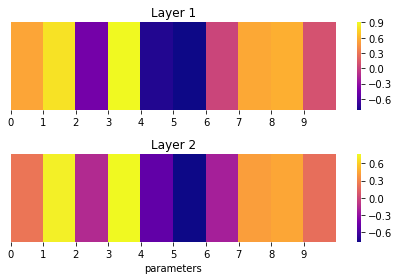

In [8]:
u.plot_layers(model)

### L1 activation penalty with pruning

In [9]:
sparse_model = SparseNet().double().to(device)
optimizer = optim.SGD(params=sparse_model.parameters(), lr=1e-3)
train_df, test_df = run(sparse_model, optimizer, 200)


[Test] Epoch: 1, Average Loss: 2.772246

[Test] Epoch: 2, Average Loss: 2.707066

[Test] Epoch: 3, Average Loss: 2.641003

[Test] Epoch: 4, Average Loss: 2.587630

[Test] Epoch: 5, Average Loss: 2.534845

[Test] Epoch: 6, Average Loss: 2.482948

[Test] Epoch: 7, Average Loss: 2.439279

[Test] Epoch: 8, Average Loss: 2.402165

[Test] Epoch: 9, Average Loss: 2.371931

[Test] Epoch: 10, Average Loss: 2.341245

[Test] Epoch: 11, Average Loss: 2.309104

[Test] Epoch: 12, Average Loss: 2.275388

[Test] Epoch: 13, Average Loss: 2.245092

[Test] Epoch: 14, Average Loss: 2.216858

[Test] Epoch: 15, Average Loss: 2.186672

[Test] Epoch: 16, Average Loss: 2.154402

[Test] Epoch: 17, Average Loss: 2.119915

[Test] Epoch: 18, Average Loss: 2.092706

[Test] Epoch: 19, Average Loss: 2.072859

[Test] Epoch: 20, Average Loss: 2.051712

[Test] Epoch: 21, Average Loss: 2.029179

[Test] Epoch: 22, Average Loss: 2.005173

[Test] Epoch: 23, Average Loss: 1.980065

[Test] Epoch: 24, Average Loss: 1.960241



/home/anand/dev/pytorch-venv/lib/python3.5/site-packages/matplotlib/pyplot.py:3261: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


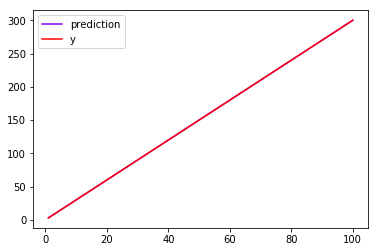

In [10]:
u.plot_df(test_df)

In [11]:
u.layer_parameters(sparse_model.fc1)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.7620,  0.0000,  0.0000,
         0.0000,  0.0000], device='cuda:0', dtype=torch.float64,
       grad_fn=<CatBackward>)

In [12]:
u.layer_parameters(sparse_model.fc2)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.7021,  0.0000,  0.0000,
         0.0000,  0.0000], device='cuda:0', dtype=torch.float64,
       grad_fn=<CatBackward>)

After sparsity regularization is applied, the network reduces to a single active link. 

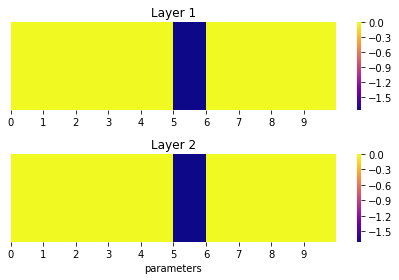

In [13]:
u.plot_layers(sparse_model)